Loaded: Order_details-masked.csv
Shape: (581, 4)
Columns: ['Name', 'Email', 'Product', 'Transaction Date']
Using time column: Transaction Date

Top 10 busiest hours (hour of day -> transactions):
 Hour  Count
   23     51
   12     51
   22     45
   19     42
   15     41
   21     41
   20     39
   11     37
   13     33
   18     33

Saved hourly counts to hourly_counts.csv


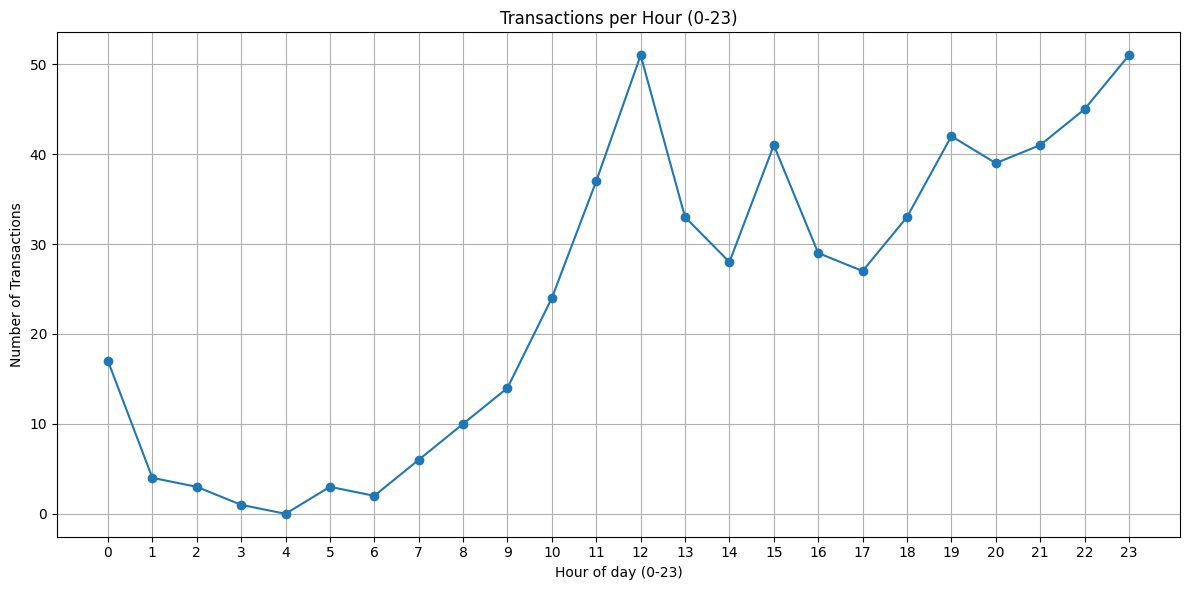

Saved plot to transactions_per_hour.png

Hourly counts (0..23):
 Hour  Count
    0     17
    1      4
    2      3
    3      1
    4      0
    5      3
    6      2
    7      6
    8     10
    9     14
   10     24
   11     37
   12     51
   13     33
   14     28
   15     41
   16     29
   17     27
   18     33
   19     42
   20     39
   21     41
   22     45
   23     51

Hour Of Day	Cumulative Number of Purchases
0		17
1		4
2		3
3		1
4		0
5		3
6		2
7		6
8		10
9		14
10		24
11		37
12		51
13		33
14		28
15		41
16		29
17		27
18		33
19		42
20		39
21		41
22		45
23		51

If running in Colab, you can download the outputs now:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Saved summary.json


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# 1) Load dataset (assumes file name exactly 'Order_details-masked.csv' in working dir)
fn = "Order_details-masked.csv"
if not os.path.exists(fn):
    raise FileNotFoundError(f"{fn} not found in working directory. Upload it (Files → Upload) or run files.upload().")

df = pd.read_csv(fn)
print("Loaded:", fn)
print("Shape:", df.shape)
print("Columns:", list(df.columns)[:20])

# 2) Convert transaction-date-like column to datetime.
# Try a few common column names. If your file uses a different column name, update the `time_col`.
candidates = ["Transaction Date", "Transaction_Date", "transaction_date", "transaction date", "TransactionDate", "Txn Date"]
time_col = None
for c in candidates:
    if c in df.columns:
        time_col = c
        break
# fallback: try to find a datetime-like column automatically
if time_col is None:
    # pick first column containing 'date' or 'time' (case-insensitive)
    for c in df.columns:
        if "date" in c.lower() or "time" in c.lower():
            time_col = c
            break

if time_col is None:
    raise ValueError("Could not find a transaction-date column automatically. Please rename your datetime column to 'Transaction Date' or tell me its name.")

print("Using time column:", time_col)

# Convert to datetime (coerce errors)
df["Time"] = pd.to_datetime(df[time_col], errors="coerce")

# Report conversion issues
n_null_time = df["Time"].isna().sum()
if n_null_time > 0:
    print(f"Warning: {n_null_time} rows could not be parsed to datetime. They will be ignored in hourly aggregation.")

# 3) Extract Hour and compute counts
df = df.dropna(subset=["Time"])   # drop unparsed timestamps
df["Hour"] = df["Time"].dt.hour

# Full hourly counts (0-23) — ensures missing hours appear with zero
hours_index = list(range(24))
hour_counts = df["Hour"].value_counts().reindex(hours_index, fill_value=0).sort_index()
hour_counts_df = pd.DataFrame({"Hour": hour_counts.index, "Count": hour_counts.values})

# 4) Print top-n busiest hours (default n=10)
n = 10
topn = hour_counts_df.sort_values("Count", ascending=False).head(n)
print(f"\nTop {n} busiest hours (hour of day -> transactions):")
print(topn.to_string(index=False))

# 5) Save hourly counts CSV
out_counts = "hourly_counts.csv"
hour_counts_df.to_csv(out_counts, index=False)
print(f"\nSaved hourly counts to {out_counts}")

# 6) Plot the hourly distribution and save PNG
plt.figure(figsize=(12,6))
plt.plot(hour_counts_df["Hour"], hour_counts_df["Count"], marker='o')
plt.xticks(hours_index)
plt.title("Transactions per Hour (0-23)")
plt.xlabel("Hour of day (0-23)")
plt.ylabel("Number of Transactions")
plt.grid(True)
plt.tight_layout()
out_png = "transactions_per_hour.png"
plt.savefig(out_png, dpi=200)
plt.show()
print(f"Saved plot to {out_png}")

# 7) Also print a nice table with hour and count
print("\nHourly counts (0..23):")
print(hour_counts_df.to_string(index=False))

# 8) Optional: produce a compact top-24 listing like the article (hour, frequency)
timemost1 = hour_counts_df["Hour"].tolist()
timemost2 = hour_counts_df["Count"].tolist()
tmost = list(zip(timemost1, timemost2))
print("\nHour Of Day\tCumulative Number of Purchases")
for h,c in tmost:
    print(f"{h}\t\t{c}")

# 9) Download helper for Colab
try:
    from google.colab import files as _files
    print("\nIf running in Colab, you can download the outputs now:")
    _files.download(out_counts)
    _files.download(out_png)
except Exception:
    pass

# 10) Short summary dictionary saved too
summary = {
    "total_transactions": int(len(df)),
    "top_hour": int(topn.iloc[0]["Hour"]),
    "top_hour_count": int(topn.iloc[0]["Count"])
}
import json
with open("summary.json", "w") as f:
    json.dump(summary, f, indent=2)
print("\nSaved summary.json")
